## Set up

In [28]:
# Imports


import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import math
import warnings
import seaborn as sns
import os
import shutil
import datetime

# Suppress specific warnings (in this case, FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sktime.clustering.k_medoids import TimeSeriesKMedoids
from scipy.fftpack import fft, fftfreq
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.clustering import KShape
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from tqdm.notebook import tqdm


In [29]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(round(math.log(abs(num), 10)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  num += letters[scale]
  return num

def mpl_human_format(x, pos):
  if pos is not None:
    return human_format(x)

def make_axes_human_readable(ax, axis="y"):
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(matplotlib.ticker.FuncFormatter(mpl_human_format))
  return ax

In [30]:
# Load the electricity usage data
NUM_CLUSTERS = 4

cluster_dfs = list()

for i in range(1, NUM_CLUSTERS + 1):
    df = pd.concat([
        pd.read_parquet(f'dataset/cluster_{i}/training.parquet'),
        pd.read_parquet(f'dataset/cluster_{i}/validation.parquet'),
        pd.read_parquet(f'dataset/cluster_{i}/test.parquet'),
    ], axis=1).T.sort_index()
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    cluster_dfs.append(df)

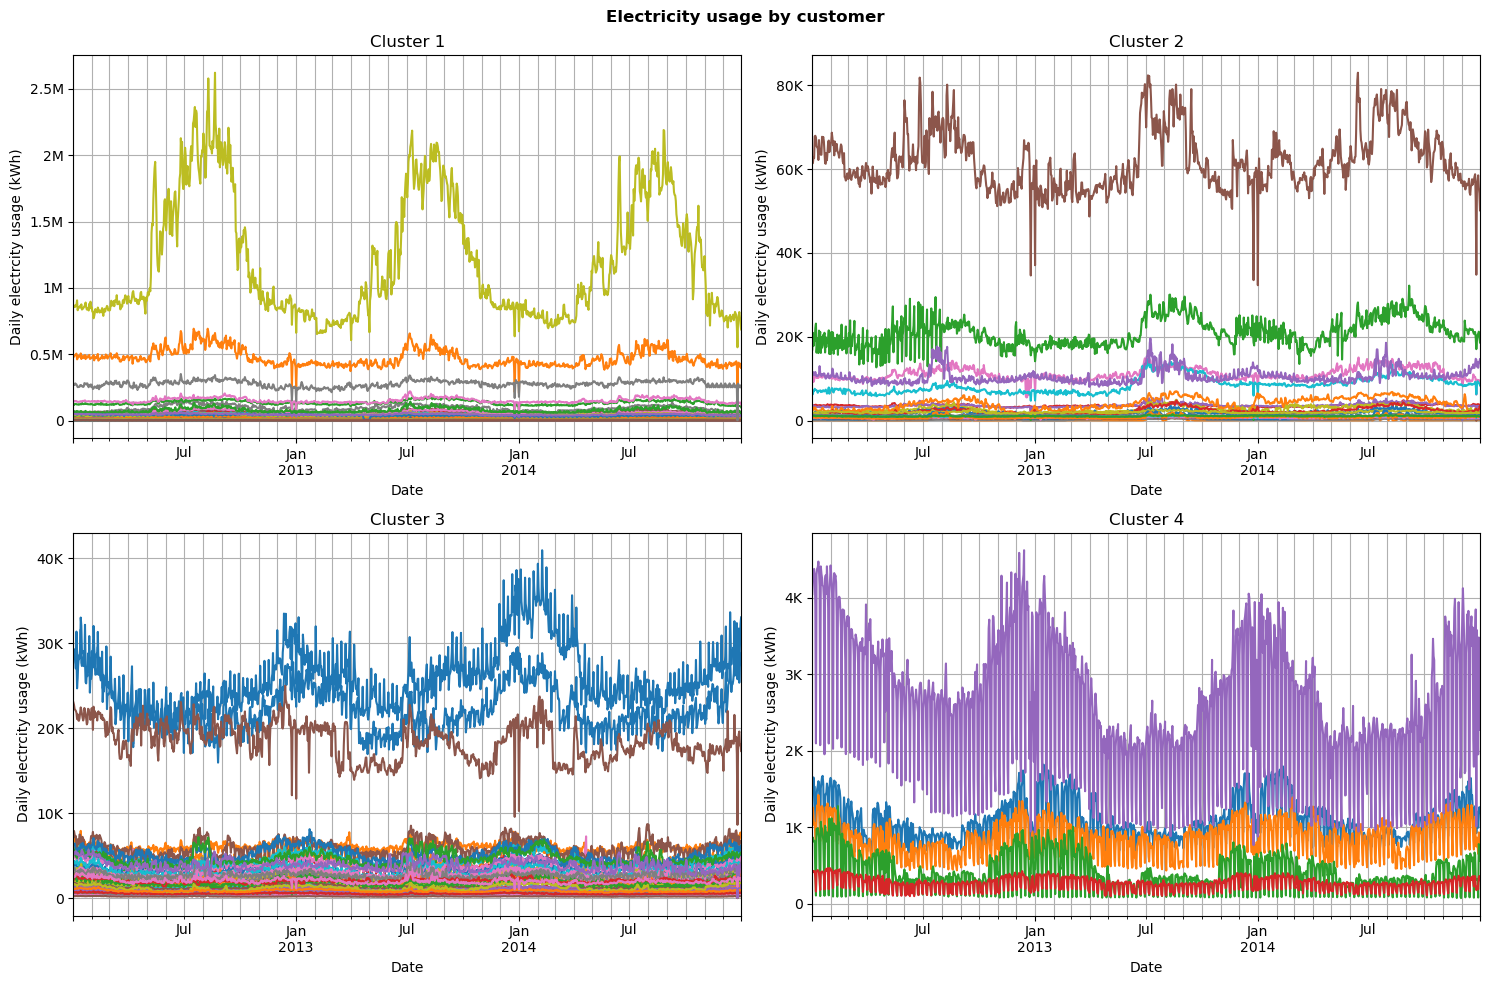

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

fig.suptitle('Electricity usage by customer', fontweight='bold')

for i, (ax, df) in enumerate(zip(axs.flatten(), cluster_dfs), start=1):
    df.plot(ax=ax)

    make_axes_human_readable(ax)
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily electrcity usage (kWh)')
    ax.grid(True, which='both')
    ax.legend().remove()

plt.tight_layout()
plt.show()

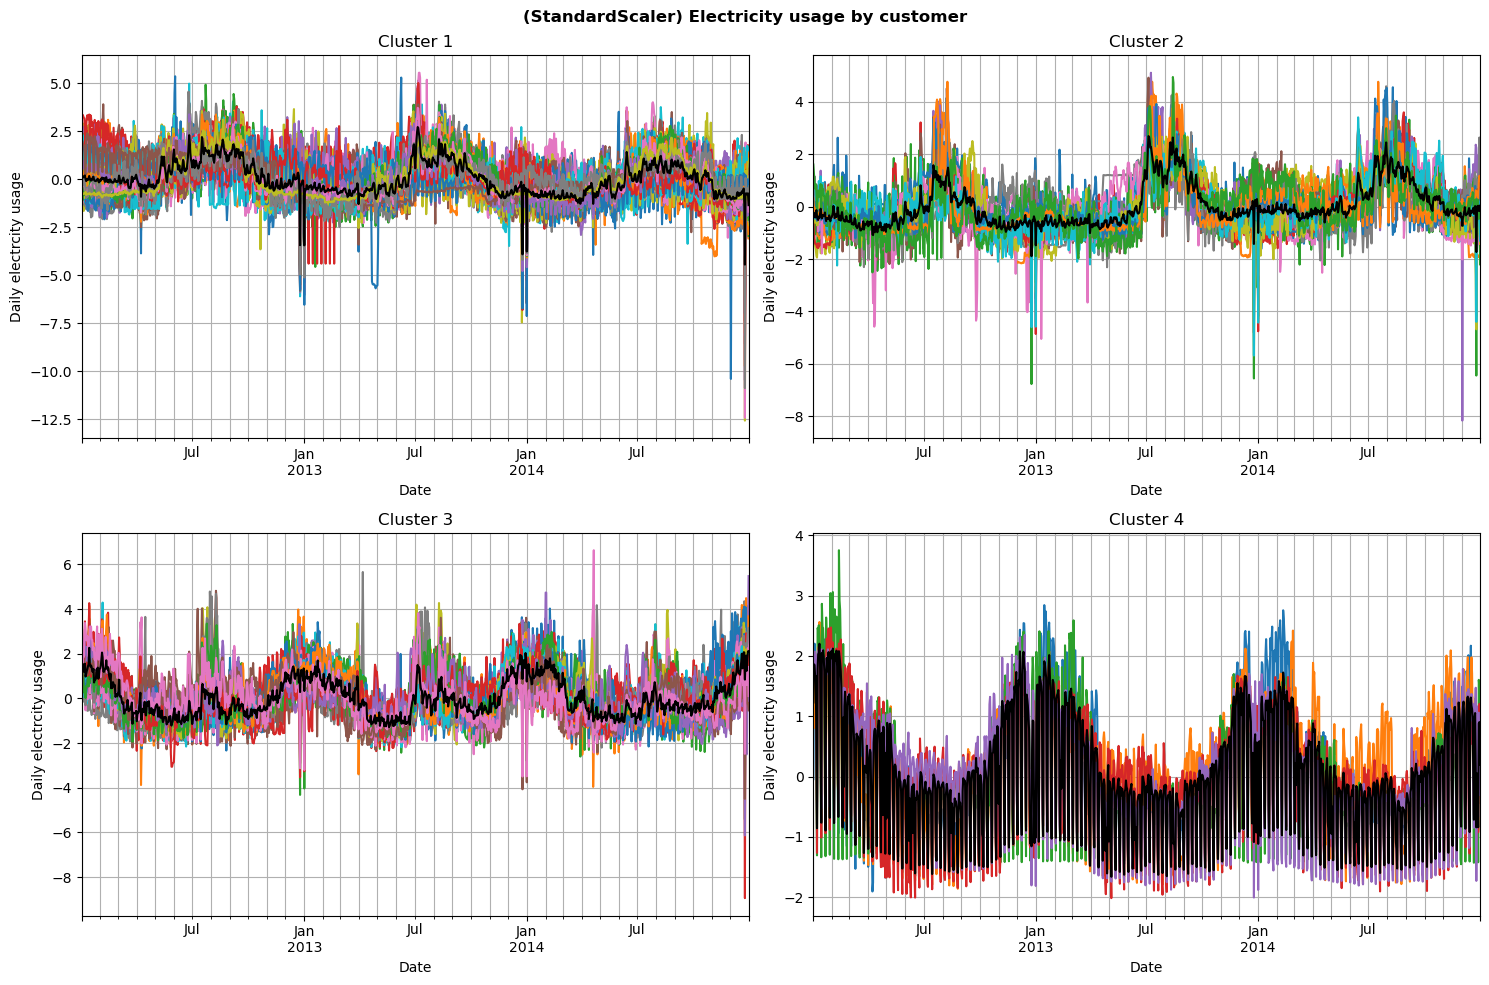

In [32]:
def plot_scaled_electrcity_usage(scaler, cluster_dfs):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    
    fig.suptitle(f'({scaler.__class__.__name__}) Electricity usage by customer', fontweight='bold')
    for i, (ax, df) in enumerate(zip(axs.flatten(), cluster_dfs), start=1):
        scaled_df = pd.DataFrame(
            scaler.fit_transform(df),
            columns=df.columns,
            index=df.index
        )
        scaled_df.plot(ax=ax)
        scaled_df.mean(axis=1).plot(ax=ax, color='black')
    
        ax.set_title(f'Cluster {i}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Daily electrcity usage')
        ax.grid(True, which='both')
        ax.legend().remove()

    plt.tight_layout()
    plt.show()


scaler = StandardScaler()
plot_scaled_electrcity_usage(scaler, cluster_dfs)

In [33]:
explanatory_variables_df = pd.read_parquet('dataset/combined_explanatory_variables/explanatory_variables.parquet')
explanatory_variables_df.index = pd.to_datetime(explanatory_variables_df.index)
explanatory_variables_df = explanatory_variables_df.sort_index().asfreq('D')
explanatory_variables_df.head()

,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,,,,,,,
2012-01-01,6.578559,0.0,0.000,0.0,0,10.0,1
2012-01-02,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,7.437771,0.0,0.000,0.0,0,10.0,0


In [34]:
melted_dfs = list()
for i, df in enumerate(cluster_dfs, start=1):
    melted_df = pd.melt(df.reset_index(), id_vars=['date'], var_name='customer', value_name='electricity_usage')
    melted_df['cluster'] = i
    melted_dfs.append(melted_df)
combined_melted_df = pd.concat(melted_dfs, axis=0)
customer_level_dataset_df = pd.merge(combined_melted_df, explanatory_variables_df, on='date', how='inner')
customer_level_dataset_df = customer_level_dataset_df.set_index(['date', 'customer', 'cluster'])
customer_level_dataset_df.head()

,,,electricity_usage,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,customer,cluster,,,,,,,,
2012-01-02,MT_091,1,3141.260841,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,MT_091,1,3424.616411,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,MT_091,1,3465.810540,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,MT_091,1,3578.052035,7.437771,0.0,0.000,0.0,0,10.0,0
2012-01-06,MT_091,1,3697.965310,8.166583,0.0,0.000,0.0,0,10.0,0


In [35]:
scaler = RobustScaler()

cutoff_date = pd.to_datetime('2014-01-01')

boxcox_dfs = list()
scaled_dfs = list()
mean_series = list()
mean_train_series = list()
mean_test_series = list()

for df in cluster_dfs:
    boxcox_df = df.apply(lambda column: boxcox(column)[0])
    scaled_df=boxcox_df
    #scaled_df = pd.DataFrame(
        #scaler.fit_transform(boxcox_df),
        #index=boxcox_df.index,
        #columns=boxcox_df.columns
    #)
    mean = scaled_df.mean(axis=1)
    mean_train = mean[mean.index < cutoff_date]
    mean_test = mean[mean.index >= cutoff_date]
    boxcox_dfs.append(boxcox_df)
    scaled_dfs.append(scaled_df)
    mean_series.append(mean)
    mean_train_series.append(mean_train)
    mean_test_series.append(mean_test)

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def test_holt_winters(training_time_series, test_time_series, 
                      trend=None, seasonal=None, seasonal_periods=365):
    
    # Fit Holt-Winters model on training data
    model = ExponentialSmoothing(
        pd.Series(training_time_series),
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    )
    
    results = model.fit(optimized=True)
    print(results.summary())
    
    # Plotting
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    
    predicted_test_time_series = results.forecast(steps=len(test_time_series)).sort_index()
    test_time_series = test_time_series.sort_index()
    
    predicted_test_time_series.plot(ax=ax, label='Predicted')
    test_time_series.plot(ax=ax, label='Actual')
    
    ax.legend()
    ax.set_title('Mean of scaled electricity usage')
    ax.set_xlabel('Date')
    ax.set_ylabel('')
    ax.grid(True, which='both')
    
    plt.tight_layout()
    plt.show()

    # Metrics
    mse = mean_squared_error(predicted_test_time_series, test_time_series)
    r2 = r2_score(predicted_test_time_series, test_time_series)
    mape = mean_absolute_percentage_error(predicted_test_time_series, test_time_series)
    print(f"\nMean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2 * 100:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

## Cluster 1

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


                           ExponentialSmoothing Model Results                           
Dep. Variable:                     None   No. Observations:                          730
Model:             ExponentialSmoothing   SSE                 9650172637214970740736.000
Optimized:                         True   AIC                                  32878.599
Trend:                         Additive   BIC                                  34573.433
Seasonal:                      Additive   AICC                                 33649.616
Seasonal Periods:                   365   Date:                         Sun, 23 Mar 2025
Box-Cox:                          False   Time:                                 02:01:29
Box-Cox Coeff.:                    None                                                 
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.

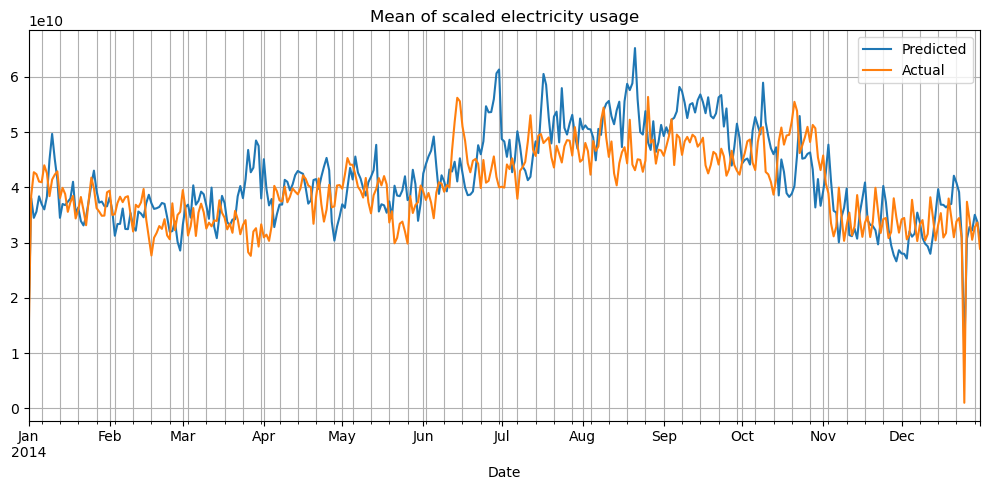


Mean Squared Error (MSE): 4.249293315816399e+19
R-squared: 36.22%
Mean Absolute Percentage Error (MAPE): 12.40%


In [38]:
i = 0
test_holt_winters(
    training_time_series=mean_train_series[i].sort_index(),
    test_time_series=mean_test_series[i].sort_index(),
    trend='add',             # or 'mul' if you suspect multiplicative trend
    seasonal='add',          # or 'mul', or None if no seasonality is present
    seasonal_periods=365     # adjust if your data is not yearly seasonal
)

## Cluster 2

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  730
Model:             ExponentialSmoothing   SSE                        2625992.636
Optimized:                         True   AIC                           6715.185
Trend:                         Additive   BIC                           8410.019
Seasonal:                      Additive   AICC                          7486.202
Seasonal Periods:                   365   Date:                 Sun, 23 Mar 2025
Box-Cox:                          False   Time:                         02:01:30
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.5874519                alpha                 True
smoothing_trend       

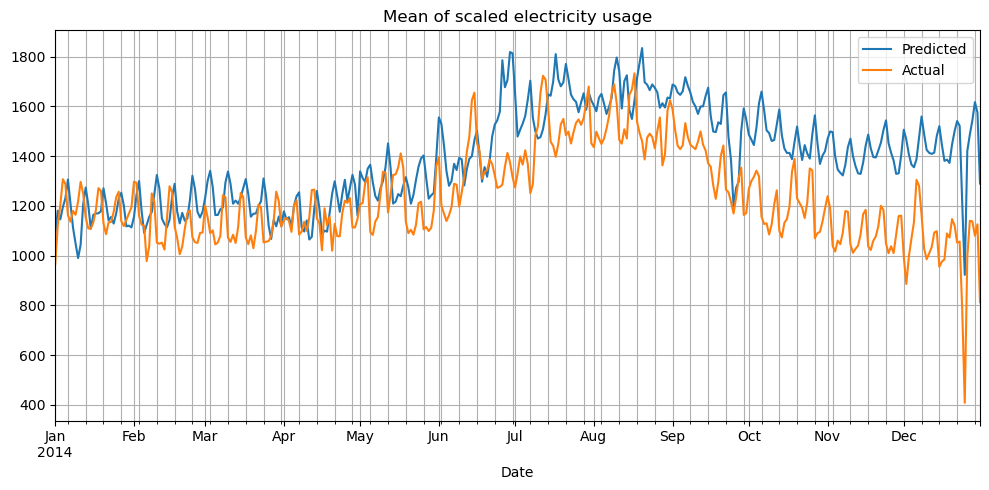


Mean Squared Error (MSE): 51788.0585142645
R-squared: -42.12%
Mean Absolute Percentage Error (MAPE): 12.82%


In [40]:
i = 1
test_holt_winters(
    training_time_series=mean_train_series[i].sort_index(),
    test_time_series=mean_test_series[i].sort_index(),
    trend='add',             # or 'mul' if you suspect multiplicative trend
    seasonal='add',          # or 'mul', or None if no seasonality is present
    seasonal_periods=365     # adjust if your data is not yearly seasonal
)

## Cluster 3

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  730
Model:             ExponentialSmoothing   SSE                    29743859878.686
Optimized:                         True   AIC                          13529.676
Trend:                         Additive   BIC                          15224.510
Seasonal:                      Additive   AICC                         14300.693
Seasonal Periods:                   365   Date:                 Sun, 23 Mar 2025
Box-Cox:                          False   Time:                         02:01:30
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.6414286                alpha                 True
smoothing_trend       

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


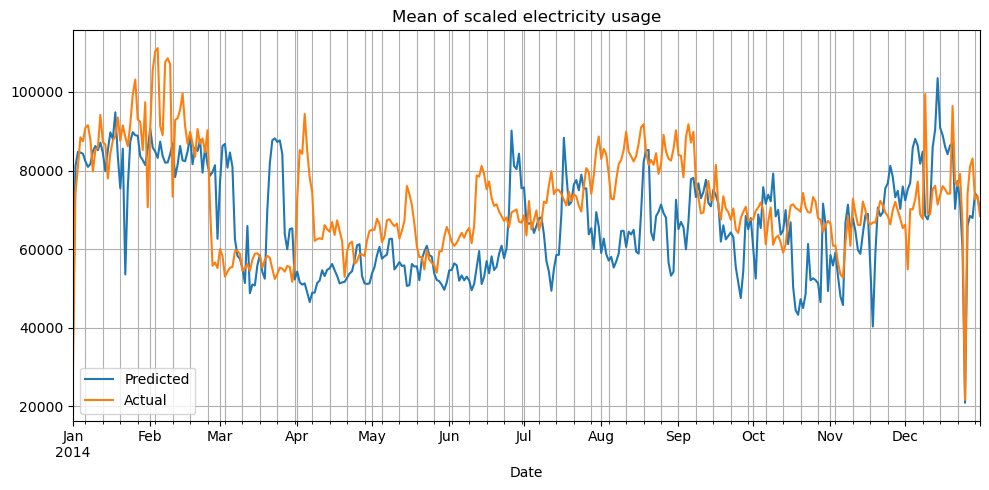


Mean Squared Error (MSE): 207675199.65405676
R-squared: -19.89%
Mean Absolute Percentage Error (MAPE): 18.16%


In [42]:
i = 2
test_holt_winters(
    training_time_series=mean_train_series[i].sort_index(),
    test_time_series=mean_test_series[i].sort_index(),
    trend='add',             # or 'mul' if you suspect multiplicative trend
    seasonal='add',          # or 'mul', or None if no seasonality is present
    seasonal_periods=365     # adjust if your data is not yearly seasonal
)

## Train Models

## Cluster 1

In [45]:
import os
import pickle
from statsmodels.tsa.holtwinters import ExponentialSmoothing

LOAD = True
MODEL_SAVE_PATH = 'models/holt_winters/cluster1/model.pickle'

i = 0
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]

if LOAD and os.path.exists(MODEL_SAVE_PATH):
    print(f'Loading model from {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'rb') as f:
        cluster_1_fit_model = pickle.load(f)
    print('Done')
else:
    print('Training model...')
    
    cluster_1_model = ExponentialSmoothing(
        mean_train,
        trend='add',                
        seasonal='add',             
        seasonal_periods=365
    )
    
    cluster_1_fit_model = cluster_1_model.fit(optimized=True)

    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'wb') as f:
        pickle.dump(cluster_1_fit_model, f)
    print('Done')

print(cluster_1_fit_model.summary())


Loading model from models/holt_winters/cluster1/model.pickle
Done
                           ExponentialSmoothing Model Results                           
Dep. Variable:                     None   No. Observations:                          730
Model:             ExponentialSmoothing   SSE                 9650172637214970740736.000
Optimized:                         True   AIC                                  32878.599
Trend:                         Additive   BIC                                  34573.433
Seasonal:                      Additive   AICC                                 33649.616
Seasonal Periods:                   365   Date:                         Sun, 23 Mar 2025
Box-Cox:                          False   Time:                                 02:01:30
Box-Cox Coeff.:                    None                                                 
                           coeff                 code              optimized      
--------------------------------------------------

## Cluster 2

In [47]:
LOAD = True
MODEL_SAVE_PATH = 'models/holt_winters/cluster2/model.pickle'

i = 1
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]

if LOAD and os.path.exists(MODEL_SAVE_PATH):
    print(f'Loading model from {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'rb') as f:
        cluster_2_fit_model = pickle.load(f)
    print('Done')
else:
    print('Training model...')
    
    cluster_2_model = ExponentialSmoothing(
        mean_train,
        trend='add',                
        seasonal='add',             
        seasonal_periods=365
    )
    
    cluster_2_fit_model = cluster_2_model.fit(optimized=True)

    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'wb') as f:
        pickle.dump(cluster_2_fit_model, f)
    print('Done')

print(cluster_2_fit_model.summary())

Loading model from models/holt_winters/cluster2/model.pickle
Done
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  730
Model:             ExponentialSmoothing   SSE                        2625992.636
Optimized:                         True   AIC                           6715.185
Trend:                         Additive   BIC                           8410.019
Seasonal:                      Additive   AICC                          7486.202
Seasonal Periods:                   365   Date:                 Sun, 23 Mar 2025
Box-Cox:                          False   Time:                         02:01:30
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.587451

## Cluster 3

In [49]:
LOAD = True
MODEL_SAVE_PATH = 'models/holt_winters/cluster3/model.pickle'

i = 2
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]

if LOAD and os.path.exists(MODEL_SAVE_PATH):
    print(f'Loading model from {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'rb') as f:
        cluster_3_fit_model = pickle.load(f)
    print('Done')
else:
    print('Training model...')
    
    cluster_3_model = ExponentialSmoothing(
        mean_train,
        trend='add',                
        seasonal='add',             
        seasonal_periods=365
    )
    
    cluster_3_fit_model = cluster_3_model.fit(optimized=True)

    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'wb') as f:
        pickle.dump(cluster_3_fit_model, f)
    print('Done')

print(cluster_3_fit_model.summary())

Loading model from models/holt_winters/cluster3/model.pickle
Done
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  730
Model:             ExponentialSmoothing   SSE                    29743859878.686
Optimized:                         True   AIC                          13529.676
Trend:                         Additive   BIC                          15224.510
Seasonal:                      Additive   AICC                         14300.693
Seasonal Periods:                   365   Date:                 Sun, 23 Mar 2025
Box-Cox:                          False   Time:                         02:01:30
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.641428

## Cluster 4

In [51]:
LOAD = True
MODEL_SAVE_PATH = 'models/holt_winters/cluster4/model.pickle'

i = 3
mean_train = mean_train_series[i]
mean_test = mean_test_series[i]

if LOAD and os.path.exists(MODEL_SAVE_PATH):
    print(f'Loading model from {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'rb') as f:
        cluster_4_fit_model = pickle.load(f)
    print('Done')
else:
    print('Training model...')
    
    cluster_4_model = ExponentialSmoothing(
        mean_train,
        trend='add',                
        seasonal='add',             
        seasonal_periods=365
    )
    
    cluster_4_fit_model = cluster_4_model.fit(optimized=True)

    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    print(f'Saving model to {MODEL_SAVE_PATH}')
    with open(MODEL_SAVE_PATH, 'wb') as f:
        pickle.dump(cluster_4_fit_model, f)
    print('Done')

print(cluster_4_fit_model.summary())

Loading model from models/holt_winters/cluster4/model.pickle
Done
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  730
Model:             ExponentialSmoothing   SSE                         709968.684
Optimized:                         True   AIC                           5760.350
Trend:                         Additive   BIC                           7455.184
Seasonal:                      Additive   AICC                          6531.367
Seasonal Periods:                   365   Date:                 Sun, 23 Mar 2025
Box-Cox:                          False   Time:                         02:01:30
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.188658

In [52]:
cluster_models = [
    pickle.load(open(f'models/holt_winters/cluster{i}/model.pickle', 'rb'))
    for i in range(1, NUM_CLUSTERS + 1)
]


## Helper functions

In [54]:
#from statsmodels.tsa.holtwinters import ExponentialSmoothing

def get_customer_predictions_holt_winters_(customer_model,
                                           scaled_test_data: pd.Series,
                                           window_size_days: int = 7,
                                           seasonal_periods: int = 365) -> pd.DataFrame:
    assert window_size_days >= 1
    scaled_test_data = scaled_test_data.sort_index()
    total_num_forecast_days = len(scaled_test_data)
    forecast_results = np.full((len(scaled_test_data.index), window_size_days), np.nan)
    series_name = scaled_test_data.name

    # We will "roll forward" by retraining the Holt-Winters model at each step
    for i in tqdm(range(total_num_forecast_days), desc=series_name, position=2, leave=False):
        forecast_len_days = min(total_num_forecast_days - i, window_size_days)
        
        # Use all available history up to this point
        history = scaled_test_data.iloc[:i+1]

        # Refit Holt-Winters using frozen smoothing parameters (alpha, beta, gamma)
        customer_model_refit = ExponentialSmoothing(
            history,
            trend=customer_model.model.trend,
            seasonal=customer_model.model.seasonal,
            seasonal_periods=seasonal_periods
        ).fit(
            smoothing_level=customer_model.params['smoothing_level'],
            smoothing_trend=customer_model.params.get('smoothing_trend', None),
            smoothing_seasonal=customer_model.params.get('smoothing_seasonal', None),
            optimized=False
        )
        
        # Forecast window
        forecast = customer_model_refit.forecast(steps=forecast_len_days)
        np.fill_diagonal(forecast_results[i:i+forecast_len_days, :forecast_len_days],
                         forecast.values)
    
    forecast_results_df = pd.DataFrame(
        forecast_results,
        index=scaled_test_data.index,
        columns=range(1, window_size_days + 1)
    )
    return forecast_results_df

def get_customer_predictions_holt_winters(cluster_model,
                                          training_data: pd.Series,
                                          test_data: pd.Series,
                                          window_size_days: int = 7,
                                          seasonal_periods: int = 365) -> pd.DataFrame:


    # Apply Box-Cox to both training and test
    boxcox_training_data, lam = boxcox(training_data)
    boxcox_training_data = pd.Series(
        boxcox_training_data,
        index=training_data.index,
        name=training_data.name,
    )
    #scaled_training_data = pd.Series(
    #    scaler.fit_transform(boxcox_training_data.reshape(-1, 1)).flatten(),
    #    index=training_data.index,
    #    name=training_data.name,
    #)

    boxcox_test_data = boxcox(test_data, lmbda=lam)
    boxcox_test_data = pd.Series(
        boxcox_test_data,
        index=test_data.index,
        name=test_data.name,
    )
    #scaled_test_data = pd.Series(
    #    scaler.transform(boxcox_test_data.reshape(-1, 1)).flatten(),
    #    index=test_data.index,
    #    name=test_data.name,
    #)

    # Forecast using inner function
    forecast_results_df = get_customer_predictions_holt_winters_(
        customer_model=cluster_model,
        scaled_test_data=boxcox_test_data,
        window_size_days=window_size_days,
        seasonal_periods=seasonal_periods
    )

    # Inverse the scaling and box-cox for each forecast
    forecast_results_df = forecast_results_df.apply(
        lambda column: inv_boxcox(
            column.values,
            lam
        ),
        axis=0,
        raw=True
    )

    return forecast_results_df

def calculate_mape_(forecast: np.ndarray, test_data: np.ndarray) -> float:
    non_na_mask = ~np.isnan(forecast) & ~np.isnan(test_data)
    forecast_filtered = forecast[non_na_mask]
    test_data_filtered = test_data[non_na_mask]
    return np.mean(np.abs((forecast_filtered - test_data_filtered) / test_data_filtered))


def calculate_mape(forecast_results_df: pd.DataFrame,
                   test_data: pd.Series) -> pd.DataFrame:
    assert (forecast_results_df.index == test_data.index).all()
    mape_df = forecast_results_df.apply(
        lambda column: calculate_mape_(column, test_data.to_numpy()),
        axis=0,
        raw=True,
    )
    return mape_df

def get_customer_predictions_and_mape_holt_winters(cluster_model,
                                                   training_data: pd.Series,
                                                   test_data: pd.Series,
                                                   window_size_days: int = 7,
                                                   seasonal_periods: int = 365) -> tuple[pd.DataFrame, pd.Series]:
    forecast_results_df = get_customer_predictions_holt_winters(
        cluster_model,
        training_data,
        test_data,
        window_size_days,
        seasonal_periods
    )

    mape = calculate_mape(forecast_results_df, test_data)

    return forecast_results_df, mape

def get_cluster_predictions_and_mape_holt_winters(cluster_model,
                                                  cluster_df: pd.DataFrame,
                                                  training_data_cutoff_date: datetime.datetime,
                                                  window_size_days: int = 7,
                                                  seasonal_periods: int = 365) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Split train and test data
    training_data_mask = cluster_df.index < training_data_cutoff_date
    training_data = cluster_df[training_data_mask].sort_index().asfreq('D')
    test_data = cluster_df[~training_data_mask].sort_index().asfreq('D')

    customer_forecast_dfs = list()
    customer_mapes = list()
    
    customers = cluster_df.columns
    for customer in tqdm(customers, desc='Customers', position=1, leave=False):
        forecast_results_df, mape = get_customer_predictions_and_mape_holt_winters(
            cluster_model,
            training_data[customer],
            test_data[customer],
            window_size_days,
            seasonal_periods
        )

        forecast_results_df['customer'] = customer
        mape.name = customer

        customer_forecast_dfs.append(forecast_results_df)
        customer_mapes.append(mape)

    customer_forecasts_df = (pd.concat(customer_forecast_dfs, axis=0)
                             .reset_index()
                             .set_index(['customer', 'date']))
    customer_mapes_df = pd.concat(customer_mapes, axis=1).T
    customer_mapes_df.index.name = 'customer'
    return customer_forecasts_df, customer_mapes_df


def get_all_predictions_and_mape_holt_winters(cluster_models: list,
                                              cluster_dfs: list[pd.DataFrame],
                                              training_data_cutoff_date: datetime.datetime,
                                              window_size_days: int = 7,
                                              seasonal_periods: int = 365) -> tuple[pd.DataFrame, pd.DataFrame]:
    cluster_forecast_dfs = list()
    cluster_mape_dfs = list()

    for i, (cluster_model, cluster_df) in tqdm(list(enumerate(zip(cluster_models, cluster_dfs), start=1)), desc='Clusters', position=0, leave=True):
        customer_forecasts_df, customer_mapes_df = get_cluster_predictions_and_mape_holt_winters(
            cluster_model,
            cluster_df,
            training_data_cutoff_date,
            window_size_days,
            seasonal_periods
        )
        customer_forecasts_df['cluster'] = i
        customer_mapes_df['cluster'] = i

        cluster_forecast_dfs.append(customer_forecasts_df)
        cluster_mape_dfs.append(customer_mapes_df)

    cluster_forecasts_df = (pd.concat(cluster_forecast_dfs, axis=0)
                            .reset_index()
                            .set_index(['cluster', 'customer', 'date']))
    cluster_mapes_df = (pd.concat(cluster_mape_dfs, axis=0)
                        .reset_index()
                        .set_index(['cluster', 'customer']))

    return cluster_forecasts_df, cluster_mapes_df



In [73]:
forescasts_df, mapes_df = get_all_predictions_and_mape_holt_winters(
    cluster_models,
    cluster_dfs,
    pd.to_datetime('2014-01-01')
)

Clusters:   0%|          | 0/4 [00:00<?, ?it/s]

Customers:   0%|          | 0/179 [00:00<?, ?it/s]

MT_091:   0%|          | 0/365 [00:00<?, ?it/s]

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [47]:
 # Pull the training, testing, and validation data
original_train_data = pd.read_parquet('dataset/cluster_1/training.parquet')
original_test_data = pd.read_parquet('dataset/cluster_1/test.parquet')
original_validation_data =  pd.read_parquet('dataset/cluster_1/validation.parquet')

In [49]:
# Calculate the sum to get the total electricity per customer per day and format it appropriately
train_total_consumption = original_train_data.sum(axis=0)
train_data = train_total_consumption.to_frame(name='y').reset_index()
train_data.columns = ['ds', 'y']

test_total_consumption = original_test_data.sum(axis=0)
test_data = test_total_consumption.to_frame(name='y').reset_index()
test_data.columns = ['ds', 'y']

validation_total_consumption = original_validation_data.sum(axis=0)
validation_data = validation_total_consumption.to_frame(name='y').reset_index()
validation_data.columns = ['ds', 'y']

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Ensure the date column is in datetime format
train_data['ds'] = pd.to_datetime(train_data['ds'])

# Set it as the index
train_data.set_index('ds', inplace=True)

# Extract the time series values
series = train_data['y']

# Fit the Holt-Winters model (Additive trend & seasonality)


In [53]:
# Forecast for the validation period
model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=365)
fitted_model = model.fit()
val_forecast = fitted_model.forecast(steps=len(validation_data))

# Evaluate performance on validation data
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE)
    - Handles division by zero by replacing zeros with a small value (1e-10)
    - Ignores NaN values

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values

    Returns:
        float: MAPE percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Replace zeros in y_true to avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)

    # Compute MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE on validation set
mape = mean_absolute_percentage_error(validation_data['y'], val_forecast)

print(f"Validation MAPE: {mape:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Validation MAE: 364158.59
Validation RMSE: 457237.65
Validation MAPE: 7.49%


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Validation MAE: 364158.59
Validation RMSE: 457237.65


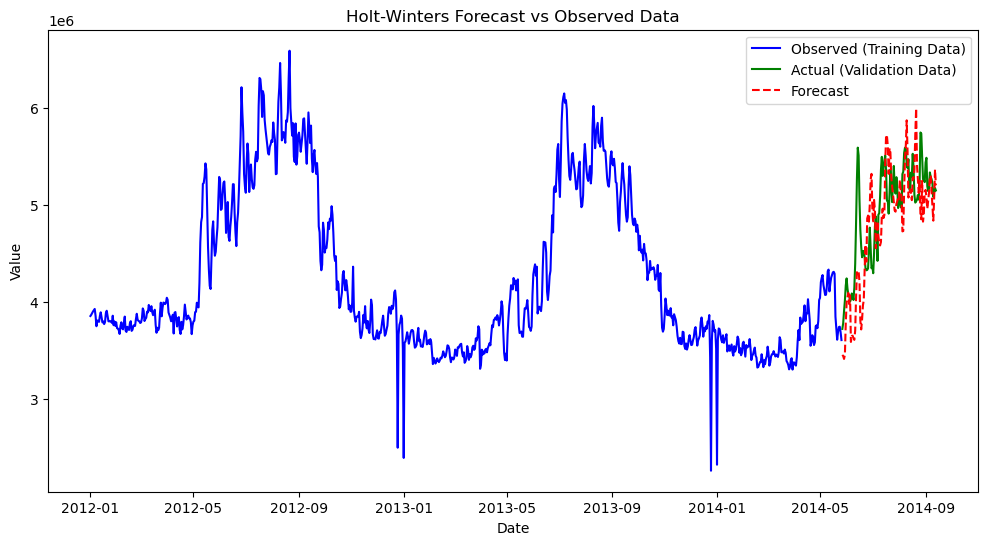

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure the validation data's date column is in datetime format
validation_data['ds'] = pd.to_datetime(validation_data['ds'])
validation_data.set_index('ds', inplace=True)

# Ensure the forecast index is also in datetime format
forecast_index = pd.date_range(start=validation_data.index[0], periods=len(validation_data), freq='D')
val_forecast = pd.Series(val_forecast, index=forecast_index)  # Assign correct datetime index

# Evaluate model performance
mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(series.index, series, label="Observed (Training Data)", color="blue")

# Plot validation (actual) data
plt.plot(validation_data.index, validation_data['y'], label="Actual (Validation Data)", color="green")

# Plot forecasted values
plt.plot(val_forecast.index, val_forecast, label="Forecast", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Holt-Winters Forecast vs Observed Data")
plt.legend()
plt.show()

In [57]:
 # Pull the training, testing, and validation data
original_train_data2 = pd.read_parquet('dataset/cluster_2/training.parquet')
original_test_data2 = pd.read_parquet('dataset/cluster_2/test.parquet')
original_validation_data2 =  pd.read_parquet('dataset/cluster_2/validation.parquet')

In [61]:
# Calculate the sum to get the total electricity per customer per day and format it appropriately
train_total_consumption = original_train_data2.sum(axis=0)
train_data = train_total_consumption.to_frame(name='y').reset_index()
train_data.columns = ['ds', 'y']

test_total_consumption = original_test_data2.sum(axis=0)
test_data = test_total_consumption.to_frame(name='y').reset_index()
test_data.columns = ['ds', 'y']

validation_total_consumption = original_validation_data2.sum(axis=0)
validation_data = validation_total_consumption.to_frame(name='y').reset_index()
validation_data.columns = ['ds', 'y']

In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Ensure the date column is in datetime format
train_data['ds'] = pd.to_datetime(train_data['ds'])

# Set it as the index
train_data.set_index('ds', inplace=True)

# Extract the time series values
series = train_data['y']

# Fit the Holt-Winters model (Additive trend & seasonality)
model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=365)
fitted_model = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [67]:
# Forecast for the validation period
val_forecast = fitted_model.forecast(steps=len(validation_data))

# Evaluate performance on validation data
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE)
    - Handles division by zero by replacing zeros with a small value (1e-10)
    - Ignores NaN values

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values

    Returns:
        float: MAPE percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Replace zeros in y_true to avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)

    # Compute MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE on validation set
mape = mean_absolute_percentage_error(validation_data['y'], val_forecast)

print(f"Validation MAPE: {mape:.2f}%")

Validation MAE: 14034.82
Validation RMSE: 16661.72
Validation MAPE: 8.28%


Validation MAE: 14034.82
Validation RMSE: 16661.72


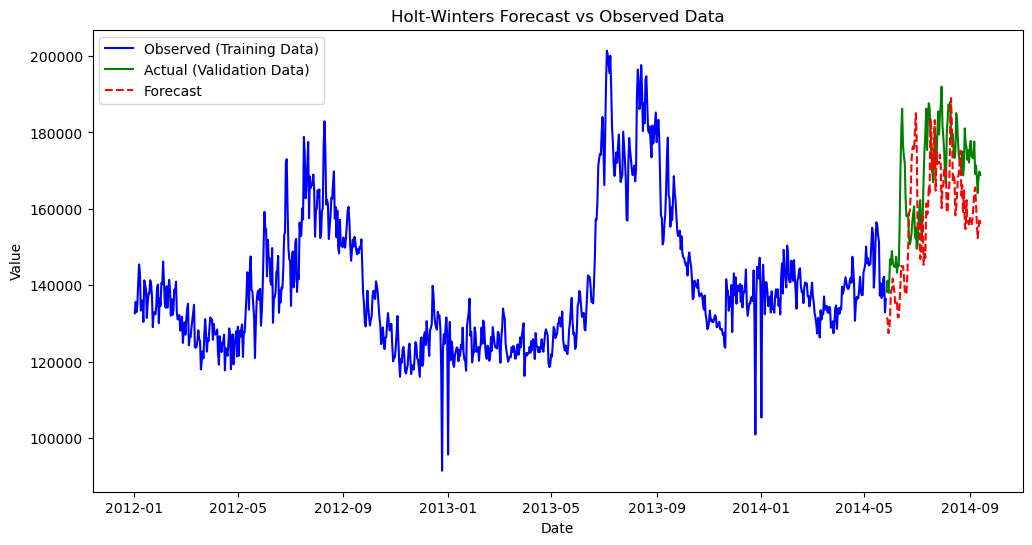

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure the validation data's date column is in datetime format
validation_data['ds'] = pd.to_datetime(validation_data['ds'])
validation_data.set_index('ds', inplace=True)

# Ensure the forecast index is also in datetime format
forecast_index = pd.date_range(start=validation_data.index[0], periods=len(validation_data), freq='D')
val_forecast = pd.Series(val_forecast, index=forecast_index)  # Assign correct datetime index

# Evaluate model performance
mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(series.index, series, label="Observed (Training Data)", color="blue")

# Plot validation (actual) data
plt.plot(validation_data.index, validation_data['y'], label="Actual (Validation Data)", color="green")

# Plot forecasted values
plt.plot(val_forecast.index, val_forecast, label="Forecast", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Holt-Winters Forecast vs Observed Data")
plt.legend()
plt.show()

In [73]:
 # Pull the training, testing, and validation data
original_train_data3 = pd.read_parquet('dataset/cluster_3/training.parquet')
original_test_data3 = pd.read_parquet('dataset/cluster_3/test.parquet')
original_validation_data3 =  pd.read_parquet('dataset/cluster_3/validation.parquet')

In [75]:
# Calculate the sum to get the total electricity per customer per day and format it appropriately
train_total_consumption = original_train_data3.sum(axis=0)
train_data = train_total_consumption.to_frame(name='y').reset_index()
train_data.columns = ['ds', 'y']

test_total_consumption = original_test_data3.sum(axis=0)
test_data = test_total_consumption.to_frame(name='y').reset_index()
test_data.columns = ['ds', 'y']

validation_total_consumption = original_validation_data3.sum(axis=0)
validation_data = validation_total_consumption.to_frame(name='y').reset_index()
validation_data.columns = ['ds', 'y']

In [77]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Ensure the date column is in datetime format
train_data['ds'] = pd.to_datetime(train_data['ds'])

# Set it as the index
train_data.set_index('ds', inplace=True)

# Extract the time series values
series = train_data['y']

# Fit the Holt-Winters model (Additive trend & seasonality)
model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=365)
fitted_model = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [79]:
# Forecast for the validation period
val_forecast = fitted_model.forecast(steps=len(validation_data))

# Evaluate performance on validation data
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE)
    - Handles division by zero by replacing zeros with a small value (1e-10)
    - Ignores NaN values

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values

    Returns:
        float: MAPE percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Replace zeros in y_true to avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)

    # Compute MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE on validation set
mape = mean_absolute_percentage_error(validation_data['y'], val_forecast)

print(f"Validation MAPE: {mape:.2f}%")

Validation MAE: 9726.91
Validation RMSE: 12110.05
Validation MAPE: 5.72%


Validation MAE: 9726.91
Validation RMSE: 12110.05


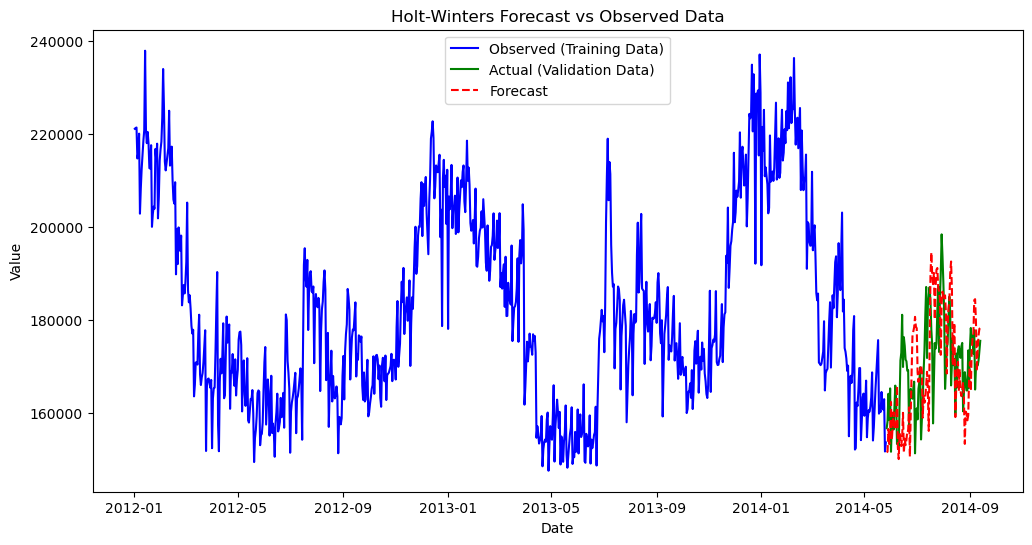

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure the validation data's date column is in datetime format
validation_data['ds'] = pd.to_datetime(validation_data['ds'])
validation_data.set_index('ds', inplace=True)

# Ensure the forecast index is also in datetime format
forecast_index = pd.date_range(start=validation_data.index[0], periods=len(validation_data), freq='D')
val_forecast = pd.Series(val_forecast, index=forecast_index)  # Assign correct datetime index

# Evaluate model performance
mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(series.index, series, label="Observed (Training Data)", color="blue")

# Plot validation (actual) data
plt.plot(validation_data.index, validation_data['y'], label="Actual (Validation Data)", color="green")

# Plot forecasted values
plt.plot(val_forecast.index, val_forecast, label="Forecast", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Holt-Winters Forecast vs Observed Data")
plt.legend()
plt.show()

In [89]:
 # Pull the training, testing, and validation data
original_train_data4 = pd.read_parquet('dataset/cluster_4/training.parquet')
original_test_data4 = pd.read_parquet('dataset/cluster_4/test.parquet')
original_validation_data4 =  pd.read_parquet('dataset/cluster_4/validation.parquet')

In [91]:
# Calculate the sum to get the total electricity per customer per day and format it appropriately
train_total_consumption = original_train_data4.sum(axis=0)
train_data = train_total_consumption.to_frame(name='y').reset_index()
train_data.columns = ['ds', 'y']

test_total_consumption = original_test_data4.sum(axis=0)
test_data = test_total_consumption.to_frame(name='y').reset_index()
test_data.columns = ['ds', 'y']

validation_total_consumption = original_validation_data4.sum(axis=0)
validation_data = validation_total_consumption.to_frame(name='y').reset_index()
validation_data.columns = ['ds', 'y']

In [95]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Ensure the date column is in datetime format
train_data['ds'] = pd.to_datetime(train_data['ds'])

# Set it as the index
train_data.set_index('ds', inplace=True)

# Extract the time series values
series = train_data['y']

# Fit the Holt-Winters model (Additive trend & seasonality)
model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=365)
fitted_model = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [97]:
# Forecast for the validation period
val_forecast = fitted_model.forecast(steps=len(validation_data))

# Evaluate performance on validation data
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE)
    - Handles division by zero by replacing zeros with a small value (1e-10)
    - Ignores NaN values

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values

    Returns:
        float: MAPE percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Replace zeros in y_true to avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)

    # Compute MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE on validation set
mape = mean_absolute_percentage_error(validation_data['y'], val_forecast)

print(f"Validation MAPE: {mape:.2f}%")

Validation MAE: 1018.20
Validation RMSE: 1278.63
Validation MAPE: 26.61%


Validation MAE: 1018.20
Validation RMSE: 1278.63


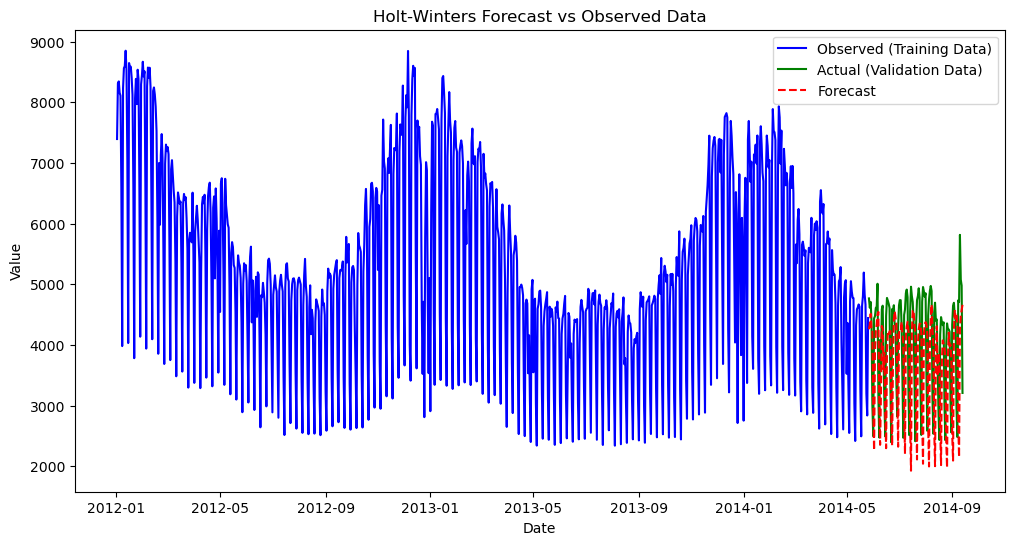

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure the validation data's date column is in datetime format
validation_data['ds'] = pd.to_datetime(validation_data['ds'])
validation_data.set_index('ds', inplace=True)

# Ensure the forecast index is also in datetime format
forecast_index = pd.date_range(start=validation_data.index[0], periods=len(validation_data), freq='D')
val_forecast = pd.Series(val_forecast, index=forecast_index)  # Assign correct datetime index

# Evaluate model performance
mae = mean_absolute_error(validation_data['y'], val_forecast)
rmse = np.sqrt(mean_squared_error(validation_data['y'], val_forecast))

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(series.index, series, label="Observed (Training Data)", color="blue")

# Plot validation (actual) data
plt.plot(validation_data.index, validation_data['y'], label="Actual (Validation Data)", color="green")

# Plot forecasted values
plt.plot(val_forecast.index, val_forecast, label="Forecast", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Holt-Winters Forecast vs Observed Data")
plt.legend()
plt.show()